# LDA multy class

In [4]:
# dữ liệu sử dụng cho ví dụ 
from sklearn import datasets                          # lấy dữ liệu
from sklearn.model_selection import train_test_split  # chia dữ liệu ra thành tập train và tập test
import numpy as np                                    # thư viện để làm việc với mảng và các hàm toán học 
from scipy.spatial import distance                    # tính khoảng cách eclipse 
import matplotlib.pyplot as plt                       # trực quan hóa dữ liệu

In [28]:
# chia dữ liệu thành tập train và tập test
# load dữ liệu
data = datasets.load_iris()
X, y = data.data, data.target
# với tập train là 75% dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0 )

# biến toàn cục
X_train_projected = None
X_test_projected = None
X_train[:5,:]

array([[5.9, 3. , 4.2, 1.5],
       [5.8, 2.6, 4. , 1.2],
       [6.8, 3. , 5.5, 2.1],
       [4.7, 3.2, 1.3, 0.2],
       [6.9, 3.1, 5.1, 2.3]])

In [6]:
class LDA:
    def __init__(self, n_components):
        # số chiều dữ liệu còn lại trong không gian mới 
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)   # liệt kê các lớp trong tập dữ liệu
        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )
        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )
        m = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))       #  within-class covariance matrix
        SB = np.zeros((n_features, n_features))       #  between-class covariance matrix
        for k in class_labels:
            X_k = X[y == k]                           # Lấy các mẫu thuộc cùng class
            m_k = np.mean(X_k, axis=0)                # Trung bình các mẫu thuộc class
            # (4, N_k) * (N_k, 4) = (4,4) 
            SW += (X_k - m_k).T.dot((X_k - m_k))
            # (4, 1) * (1, 4) = (4,4) -> reshape
            N_k = X_k.shape[0]
            mean_diff = (m_k - m).reshape(n_features, 1)
            SB += N_k * (mean_diff).dot(mean_diff.T)
        # Tính SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB) 
        # Tính trị riêng và vector riêng của SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)    
        # sắp xếp trị riêng từ lớn đến bé
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]     
        # giữ lại n_components vector ứng với các giá trị riêng lớn nhất
        self.linear_discriminants = eigenvectors[0 : self.n_components]
    def transform(self, X):
        # chiếu dữ liệu sang không gian mới 
        return np.dot(X, self.linear_discriminants.T)


#### Giảm chiều dữ liệu xuống còn 2

Shape of X: (112, 4)
Shape of y: (112,)
Shape of transformed X: (112, 2)


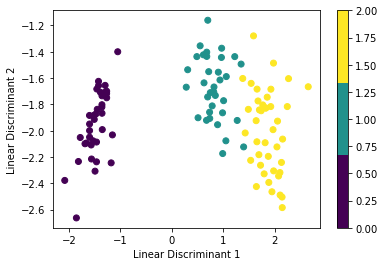

In [7]:
# Testing
if __name__ == "__main__":
    
    # Chiếu dữ liệu trong không gian 4 chiều ban đầu sang không gian 2 chiều   
    lda = LDA(2)
    lda.fit(X_train, y_train)
    X_train_projected = lda.transform(X_train)

    print("Shape of X:", X_train.shape)
    print("Shape of y:", y_train.shape)
    print("Shape of transformed X:", X_train_projected.shape)

    x1, x2 = X_train_projected[:, 0], X_train_projected[:, 1]
    plt.scatter(x1, x2, c=y_train, alpha=1, cmap=plt.cm.get_cmap("viridis", 3))
    
    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.colorbar()
    plt.show()

In [8]:
# Chiếu tập dữ liệu test vào không gian mới 
X_test_projected = lda.transform(X_test)

In [9]:
# Tính trung bình của mỗi class trong không gian mới  
means = np.array([None,None,None])
class_labels = np.unique(y_train)
for c in class_labels:
    X_c = X_train_projected[y_train == c]
    means[c] = np.mean(X_c, axis=0)

In [11]:
# tính khoảng cách eclipse và và dự đoán class dựa trên khoảng cách nhỏ nhất đến các điểm trung tâm mỗi class
y_test_predict = np.zeros(y_test.shape, dtype = 'i1') 
for i in range(X_test_projected.shape[0]):
    dis = [distance.euclidean(means[j], X_test_projected[i]) for j in range(3)]
    y_test_predict[i] = np.argmin(dis)

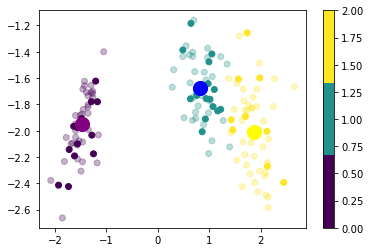

In [14]:
# vẽ dữ liệu trong không gian mới (2 chiều) với các điểm trung tâm
x_test1, x_test2 = X_test_projected[:, 0], X_test_projected[:, 1]
x1, x2 = X_train_projected[:, 0], X_train_projected[:, 1]

plt.scatter(x1, x2, c=y_train, alpha=0.3, cmap=plt.cm.get_cmap("viridis", 3))

plt.scatter(x_test1, x_test2, c=y_test_predict, alpha=1, cmap=plt.cm.get_cmap("viridis", 3))
plt.colorbar()

plt.scatter(means[0][0],means[0][1],200, c = 'purple')
plt.scatter(means[1][0],means[1][1],200, c = 'blue')
plt.scatter(means[2][0],means[2][1],200, c = 'yellow')


In [16]:
# tính độ chính xác
s = np.sum(y_test_predict==y_test)
print("accuracy = ", s * 100/y_test.size, "%")

accuracy =  97.36842105263158 %


#### Giảm chiều dữ liệu còn 3

In [29]:
# Giảm chiều dữ liệu từ 4 chiều xuống 3 chiều
lda = LDA(3)
lda.fit(X_train, y_train)
X_train_projected = lda.transform(X_train)
x_test_predict = lda.transform(X_test)

In [18]:
# Tìm điểm trung tâm của mỗi class
means1 = np.array([None,None,None])
class_labels = np.unique(y_train)
for c in class_labels:
    X_c = X_train_projected[y_train == c]
    means1[c] = np.mean(X_c, axis=0)

In [19]:
# Dự đoán nhãn cho dữ liệu test
for i in range(X_test.shape[0]):
    dis = [distance.euclidean(means1[j], x_test_predict[i]) for j in range(3)]
    y_test_predict[i] = np.argmin(dis)

In [21]:
# tính độ chính xác
s = np.sum(y_test_predict==y_test)
print("accuracy = ", s * 100/y_test.size, "%")

accuracy =  97.36842105263158 %


### Để nguyên số chiều dữ liệu là 4

In [24]:
# Tìm điểm trung tâm của mỗi class
means1 = np.array([None,None,None])
class_labels = np.unique(y_train)
for c in class_labels:
    X_c = X_train[y_train == c]
    means1[c] = np.mean(X_c, axis=0)

In [25]:
# Dự đoán nhãn cho dữ liệu test
for i in range(X_test.shape[0]):
    dis = [distance.euclidean(means1[j], X_test[i]) for j in range(3)]
    y_test_predict[i] = np.argmin(dis)

In [27]:
# tính độ chính xác
s = np.sum(y_test_predict==y_test)
print("accuracy = ", s * 100/y_test.size, "%")

accuracy =  89.47368421052632 %


#### Giảm xuống 1 chiều 

In [30]:
# Giảm chiều dữ liệu từ 4 chiều xuống 1 chiều
lda = LDA(3)
lda.fit(X_train, y_train)
X_train_projected = lda.transform(X_train)
x_test_predict = lda.transform(X_test)

In [31]:
# Tìm điểm trung tâm của mỗi class
means1 = np.array([None,None,None])
class_labels = np.unique(y_train)
for c in class_labels:
    X_c = X_train_projected[y_train == c]
    means1[c] = np.mean(X_c, axis=0)

In [32]:
# Dự đoán nhãn cho dữ liệu test
for i in range(X_test.shape[0]):
    dis = [distance.euclidean(means1[j], x_test_predict[i]) for j in range(3)]
    y_test_predict[i] = np.argmin(dis)

In [33]:
# tính độ chính xác
s = np.sum(y_test_predict==y_test)
print("accuracy = ", s * 100/y_test.size, "%")

accuracy =  97.36842105263158 %
